# Imports

In [1]:
from dqn.dqn import QNetwork, ReplayMemory
from policies.eps_greedy import EpsilonGreedyPolicy
from train_eval.train import train as train_baseline
from train_eval.train_clipping import train as train_clipping

import random
import numpy as np
import torch
from torch import optim
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy

# Load the environment

In [2]:
env = gym.envs.make("CartPole-v1")

# Function to run episodes and call training function (baseline)

In [3]:
def run_episodes(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, optimizer):
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    state_values = []
    init_state = env.reset()
    for i in tqdm(range(1, num_episodes+1)):
        state = env.reset()

        steps = 0
        while True:
            # Set epsilon according to number of steps
            policy.set_epsilon(global_steps)
            # Increase step counts
            steps += 1
            global_steps += 1
            # Sample an action, next state, reward and done
            a = policy.sample_action(state)
            s_next, r, done, _ = env.step(a)
            # Add the transition to the memory buffer
            memory.push((state, a, r, s_next, done))
            # Perform training on the buffer
            if global_steps % batch_size == 0:
                loss = train(Q, memory, optimizer, batch_size, discount_factor)
            state = s_next

            if done:
                episode_durations.append(steps)
                break
        if i == 1 or i % 100 == 0:
            with torch.no_grad():
                Q.eval()
                Q_vals = Q(torch.Tensor([init_state]))
                maxx, _ = torch.max(Q_vals, dim=1)
                state_values.append(maxx)
    return episode_durations, state_values

# Train network

In [18]:
seed = 42  # This is not randomly chosen
num_hidden = 128
eps = 0.05

# We will seed the algorithm (before initializing QNetwork!) for reproducibility
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

Q_net = QNetwork(num_hidden=num_hidden)
policy = EpsilonGreedyPolicy(Q_net, eps)

num_episodes = 10000
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(batch_size)

optimizer = optim.Adam(Q_net.parameters(), learn_rate)
episode_durations, state_values = run_episodes(train_baseline, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, optimizer)


 36%|███████████████████████████▏                                                | 3585/10000 [00:07<00:14, 436.10it/s]


 59%|█████████████████████████████████████████████▋                               | 5941/10000 [00:16<01:28, 45.61it/s]


 63%|████████████████████████████████████████████████▏                            | 6253/10000 [00:24<02:10, 28.80it/s]


 65%|██████████████████████████████████████████████████▍                          | 6548/10000 [00:34<01:57, 29.48it/s]


 69%|█████████████████████████████████████████████████████▏                       | 6902/10000 [00:47<02:46, 18.55it/s]


 71%|██████████████████████████████████████████████████████▉                      | 7139/10000 [00:56<01:36, 29.51it/s]


 82%|███████████████████████████████████████████████████████████████▎             | 8228/10000 [01:06<00:40, 43.28it/s]


 84%|████████████████████████████████████████████████████████████████▊            | 8410/10000 [01:17<01:40, 15.86it/s]


 86%|█████████████████████████████████████████████████████████████████▉           | 8564/10000 [01:26<01:17, 18.49it/s]


 87%|███████████████████████████████████████████████████████████████████▎         | 8744/10000 [01:36<01:22, 15.31it/s]


 89%|████████████████████████████████████████████████████████████████████▉        | 8946/10000 [01:45<00:31, 33.22it/s]


 94%|████████████████████████████████████████████████████████████████████████▏    | 9367/10000 [01:56<00:36, 17.57it/s]


 95%|█████████████████████████████████████████████████████████████████████████▌   | 9549/10000 [02:04<00:18, 24.03it/s]


 98%|███████████████████████████████████████████████████████████████████████████▌ | 9811/10000 [02:12<00:05, 36.87it/s]


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:16<00:00, 73.21it/s]


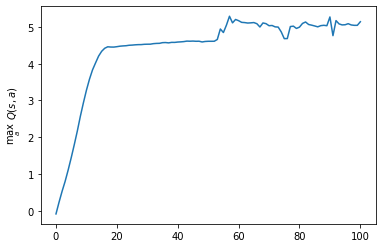

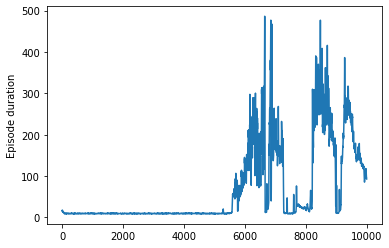

In [19]:
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


plt.plot(np.array(state_values))
plt.ylabel('$\max_a\ Q(s,a)$')
plt.show()

plt.plot(smooth(np.array(episode_durations), 10))
plt.ylabel('Episode duration')
plt.show()

In [7]:
def run_episodes_clipping(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, optimizer, clip_norm):
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    state_values = []
    init_state = env.reset()
    for i in tqdm(range(1, num_episodes+1)):
        state = env.reset()

        steps = 0
        while True:
            # Set epsilon according to number of steps
            policy.set_epsilon(global_steps)
            # Increase step counts
            steps += 1
            global_steps += 1
            # Sample an action, next state, reward and done
            a = policy.sample_action(state)
            s_next, r, done, _ = env.step(a)
            # Add the transition to the memory buffer
            memory.push((state, a, r, s_next, done))
            # Perform training on the buffer
            if global_steps % batch_size == 0:
                loss = train(Q, memory, optimizer, batch_size, discount_factor, clip_norm)
            state = s_next

            if done:
                episode_durations.append(steps)
                break
        if i == 1 or i % 100 == 0:
            with torch.no_grad():
                Q.eval()
                Q_vals = Q(torch.Tensor([init_state]))
                maxx, _ = torch.max(Q_vals, dim=1)
                state_values.append(maxx)
    return episode_durations, state_values

In [16]:
# Fixed hyperparams among experiments
num_hidden = 128
eps = 0.05
num_episodes = 10000
batch_size = 64
learn_rate = 1e-3

# Number of experiments to average results over
num_experiments = 2

# Different values of gamma to be tested
clip_norms = [0.5, 1, 5, 10]

# Make buffers for the cumulative results
cum_state_values = {i : [] for i in clip_norms}
cum_episode_durations = {i : [] for i in clip_norms}

for clip_norm in clip_norms:
    for i in range(num_experiments):
        
        # Set the seed such that each update frequency is tested on the same seeds
        random.seed(i)
        torch.manual_seed(i)
        env.seed(i)
        
        # Create network, policy and replaymemory (which is not used; renewed every batch)
        Q_net = QNetwork(num_hidden=num_hidden)
        policy = EpsilonGreedyPolicy(Q_net, eps)
        memory = ReplayMemory(batch_size)

        optimizer = optim.Adam(Q_net.parameters(), learn_rate)
        episode_durations, state_values = run_episodes_clipping(
            train_clipping,
            Q_net,
            policy,
            memory,
            env,
            num_episodes,
            batch_size,
            discount_factor,
            optimizer,
            clip_norm
        )
        cum_state_values[clip_norm].append(np.array(state_values))
        cum_episode_durations[clip_norm].append(np.array(episode_durations))


 36%|███████████████████████████▎                                                | 3598/10000 [00:06<00:10, 606.17it/s]


 77%|██████████████████████████████████████████████████████████▊                 | 7740/10000 [00:13<00:04, 518.33it/s]


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 547.95it/s]

  9%|██████▋                                                                      | 865/10000 [00:02<00:16, 561.74it/s]


 50%|██████████████████████████████████████                                      | 5007/10000 [00:09<00:08, 559.79it/s]


 88%|███████████████████████████████████████████████████████████████████         | 8827/10000 [00:16<00:02, 526.57it/s]


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 520.41it/s]

 22%|████████████████▊                                                           | 2207/10000 [00:04<00:16, 463.69it/s]


 57%|██████████████████████████████████████████▉                                 | 5654/10000 [00:11<00:09, 482.86it/s]


 90%|████████████████████████████████████████████████████████████████████▌       | 9019/10000 [00:18<00:01, 516.74it/s]


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 488.38it/s]

 19%|██████████████▎                                                             | 1875/10000 [00:04<00:18, 445.53it/s]


 54%|████████████████████████████████████████▉                                   | 5383/10000 [00:11<00:09, 510.97it/s]


 89%|███████████████████████████████████████████████████████████████████▌        | 8896/10000 [00:18<00:02, 467.86it/s]


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 470.52it/s]

 22%|████████████████▉                                                           | 2223/10000 [00:04<00:19, 407.53it/s]


 37%|███████████████████████████▉                                                | 3684/10000 [00:12<00:59, 106.76it/s]


 42%|████████████████████████████████▎                                            | 4204/10000 [00:21<04:35, 21.05it/s]


 44%|██████████████████████████████████                                           | 4419/10000 [00:30<03:48, 24.47it/s]


 46%|███████████████████████████████████▍                                         | 4605/10000 [00:40<04:29, 20.01it/s]


 48%|████████████████████████████████████▌                                        | 4756/10000 [00:52<05:40, 15.39it/s]


 49%|█████████████████████████████████████▊                                       | 4908/10000 [01:03<08:35,  9.88it/s]


 51%|███████████████████████████████████████                                      | 5076/10000 [01:12<07:01, 11.68it/s]


 52%|████████████████████████████████████████                                     | 5211/10000 [01:23<04:40, 17.05it/s]


 54%|█████████████████████████████████████████▌                                   | 5392/10000 [01:33<05:22, 14.30it/s]


 60%|██████████████████████████████████████████████                               | 5975/10000 [01:46<05:43, 11.72it/s]


 61%|███████████████████████████████████████████████                              | 6110/10000 [01:57<05:47, 11.18it/s]


 62%|████████████████████████████████████████████████                             | 6245/10000 [02:08<04:18, 14.52it/s]


 64%|█████████████████████████████████████████████████                            | 6378/10000 [02:19<05:20, 11.29it/s]


 66%|██████████████████████████████████████████████████▍                          | 6553/10000 [02:27<02:04, 27.62it/s]


 68%|████████████████████████████████████████████████████▎                        | 6790/10000 [02:36<03:30, 15.24it/s]


 69%|█████████████████████████████████████████████████████▍                       | 6944/10000 [02:46<03:13, 15.76it/s]


 71%|██████████████████████████████████████████████████████▌                      | 7078/10000 [02:55<03:45, 12.98it/s]


 72%|███████████████████████████████████████████████████████▋                     | 7234/10000 [03:05<02:08, 21.54it/s]


 74%|█████████████████████████████████████████████████████████▎                   | 7449/10000 [03:13<01:29, 28.40it/s]


 77%|███████████████████████████████████████████████████████████                  | 7667/10000 [03:22<01:49, 21.25it/s]


 79%|████████████████████████████████████████████████████████████▌                | 7861/10000 [03:31<01:29, 23.92it/s]


 81%|██████████████████████████████████████████████████████████████               | 8060/10000 [03:40<02:04, 15.55it/s]


 82%|███████████████████████████████████████████████████████████████▎             | 8229/10000 [03:49<01:37, 18.15it/s]


 84%|████████████████████████████████████████████████████████████████▍            | 8376/10000 [03:59<01:48, 14.97it/s]


 85%|█████████████████████████████████████████████████████████████████▌           | 8522/10000 [04:08<01:42, 14.39it/s]


 91%|█████████████████████████████████████████████████████████████████████▋       | 9056/10000 [04:20<00:53, 17.69it/s]


 92%|██████████████████████████████████████████████████████████████████████▊      | 9190/10000 [04:30<01:02, 12.96it/s]


 93%|███████████████████████████████████████████████████████████████████████▊     | 9322/10000 [04:40<00:50, 13.32it/s]


 94%|████████████████████████████████████████████████████████████████████████▋    | 9443/10000 [04:52<00:58,  9.50it/s]


 96%|█████████████████████████████████████████████████████████████████████████▋   | 9571/10000 [05:03<00:39, 10.86it/s]


 97%|██████████████████████████████████████████████████████████████████████████▋  | 9703/10000 [05:15<00:27, 10.71it/s]


 98%|███████████████████████████████████████████████████████████████████████████▋ | 9828/10000 [05:26<00:14, 11.96it/s]


100%|████████████████████████████████████████████████████████████████████████████▋| 9958/10000 [05:37<00:03, 11.41it/s]


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:40<00:00, 29.34it/s]

 18%|█████████████▊                                                              | 1821/10000 [00:04<00:16, 498.09it/s]


 33%|█████████████████████████▏                                                   | 3275/10000 [00:12<01:17, 86.51it/s]


 39%|█████████████████████████████▋                                               | 3857/10000 [00:20<01:03, 97.46it/s]


 42%|████████████████████████████████▏                                            | 4183/10000 [00:35<10:45,  9.01it/s]


 43%|████████████████████████████████▊                                            | 4262/10000 [00:43<11:25,  8.37it/s]


 44%|█████████████████████████████████▌                                           | 4364/10000 [00:54<09:44,  9.64it/s]


 45%|██████████████████████████████████▌                                          | 4491/10000 [01:06<08:34, 10.71it/s]


 46%|███████████████████████████████████▌                                         | 4614/10000 [01:18<08:22, 10.72it/s]


 51%|███████████████████████████████████████▎                                     | 5111/10000 [01:37<08:32,  9.54it/s]


 52%|████████████████████████████████████████▎                                    | 5240/10000 [01:49<07:25, 10.68it/s]


 54%|█████████████████████████████████████████▎                                   | 5365/10000 [02:01<07:34, 10.21it/s]


 55%|██████████████████████████████████████████▎                                  | 5488/10000 [02:13<07:24, 10.14it/s]


 56%|███████████████████████████████████████████▎                                 | 5622/10000 [02:24<08:55,  8.17it/s]


 57%|████████████████████████████████████████████▏                                | 5739/10000 [02:34<04:42, 15.10it/s]


 59%|█████████████████████████████████████████████▏                               | 5870/10000 [02:45<06:41, 10.29it/s]


 60%|██████████████████████████████████████████████▏                              | 6001/10000 [02:56<03:57, 16.84it/s]


 61%|███████████████████████████████████████████████▎                             | 6149/10000 [03:06<03:58, 16.15it/s]


 63%|████████████████████████████████████████████████▍                            | 6294/10000 [03:15<02:36, 23.64it/s]


 65%|██████████████████████████████████████████████████                           | 6506/10000 [03:24<02:42, 21.52it/s]


 67%|███████████████████████████████████████████████████▌                         | 6697/10000 [03:32<03:20, 16.44it/s]


 69%|████████████████████████████████████████████████████▊                        | 6860/10000 [03:42<05:15,  9.95it/s]


 70%|██████████████████████████████████████████████████████▏                      | 7035/10000 [03:51<02:48, 17.59it/s]


 72%|███████████████████████████████████████████████████████▏                     | 7168/10000 [04:02<03:54, 12.09it/s]


 73%|████████████████████████████████████████████████████████▏                    | 7303/10000 [04:14<03:15, 13.77it/s]


 80%|█████████████████████████████████████████████████████████████▍               | 7972/10000 [04:31<03:58,  8.51it/s]


 81%|██████████████████████████████████████████████████████████████               | 8063/10000 [04:41<03:55,  8.21it/s]


 82%|███████████████████████████████████████████████████████████████▏             | 8211/10000 [04:51<01:55, 15.52it/s]


 83%|████████████████████████████████████████████████████████████████▎            | 8348/10000 [05:01<03:34,  7.71it/s]


 85%|█████████████████████████████████████████████████████████████████▎           | 8480/10000 [05:11<02:07, 11.89it/s]


 86%|██████████████████████████████████████████████████████████████████▏          | 8597/10000 [05:22<02:08, 10.88it/s]


 87%|███████████████████████████████████████████████████████████████████▏         | 8718/10000 [05:34<02:20,  9.10it/s]


 88%|███████████████████████████████████████████████████████████████████▉         | 8818/10000 [05:44<01:38, 12.03it/s]


 90%|████████████████████████████████████████████████████████████████████▉        | 8952/10000 [05:55<01:29, 11.71it/s]


 95%|█████████████████████████████████████████████████████████████████████████▍   | 9537/10000 [06:09<00:20, 22.95it/s]


 97%|██████████████████████████████████████████████████████████████████████████▌  | 9691/10000 [06:18<00:21, 14.51it/s]


 98%|███████████████████████████████████████████████████████████████████████████▋ | 9823/10000 [06:28<00:12, 14.00it/s]


100%|████████████████████████████████████████████████████████████████████████████▋| 9958/10000 [06:38<00:02, 14.98it/s]


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:42<00:00, 24.84it/s]

 23%|█████████████████▍                                                          | 2290/10000 [00:04<00:20, 367.25it/s]


 39%|█████████████████████████████▎                                              | 3864/10000 [00:12<00:53, 114.11it/s]


 46%|███████████████████████████████████                                          | 4557/10000 [00:20<01:38, 55.12it/s]


 49%|█████████████████████████████████████▌                                       | 4876/10000 [00:29<04:02, 21.13it/s]


 50%|██████████████████████████████████████▌                                      | 5016/10000 [00:40<08:42,  9.54it/s]


 51%|███████████████████████████████████████▍                                     | 5116/10000 [00:50<07:54, 10.29it/s]


 52%|████████████████████████████████████████▎                                    | 5239/10000 [01:01<09:00,  8.81it/s]


 53%|█████████████████████████████████████████                                    | 5325/10000 [01:10<08:04,  9.65it/s]


 55%|██████████████████████████████████████████                                   | 5461/10000 [01:21<08:42,  8.68it/s]


 61%|██████████████████████████████████████████████▋                              | 6065/10000 [01:32<02:36, 25.09it/s]


 63%|████████████████████████████████████████████████▌                            | 6309/10000 [01:40<02:09, 28.45it/s]


 65%|██████████████████████████████████████████████████▍                          | 6546/10000 [01:48<02:45, 20.83it/s]


 67%|███████████████████████████████████████████████████▋                         | 6706/10000 [01:58<04:23, 12.51it/s]


 68%|████████████████████████████████████████████████████▋                        | 6850/10000 [02:08<05:21,  9.79it/s]


 70%|█████████████████████████████████████████████████████▊                       | 6981/10000 [02:19<04:10, 12.05it/s]


 71%|██████████████████████████████████████████████████████▋                      | 7106/10000 [02:31<04:22, 11.02it/s]


 73%|███████████████████████████████████████████████████████▉                     | 7257/10000 [02:41<03:36, 12.70it/s]


 74%|████████████████████████████████████████████████████████▊                    | 7384/10000 [02:52<03:54, 11.14it/s]


 75%|█████████████████████████████████████████████████████████▋                   | 7494/10000 [03:03<05:45,  7.26it/s]


 76%|██████████████████████████████████████████████████████████▎                  | 7572/10000 [03:13<07:19,  5.52it/s]


 77%|██████████████████████████████████████████████████████████▉                  | 7654/10000 [03:23<04:29,  8.72it/s]


 82%|██████████████████████████████████████████████████████████████▉              | 8173/10000 [03:39<02:42, 11.24it/s]


 83%|███████████████████████████████████████████████████████████████▋             | 8269/10000 [03:51<03:54,  7.38it/s]


 84%|████████████████████████████████████████████████████████████████▌            | 8378/10000 [04:02<02:29, 10.81it/s]


 85%|█████████████████████████████████████████████████████████████████▍           | 8502/10000 [04:14<02:20, 10.67it/s]


 86%|██████████████████████████████████████████████████████████████████▎          | 8619/10000 [04:25<02:11, 10.48it/s]


 87%|███████████████████████████████████████████████████████████████████▏         | 8719/10000 [04:36<02:08,  9.98it/s]


 88%|███████████████████████████████████████████████████████████████████▉         | 8816/10000 [04:46<02:10,  9.10it/s]


 89%|████████████████████████████████████████████████████████████████████▊        | 8939/10000 [04:56<01:27, 12.11it/s]


 91%|█████████████████████████████████████████████████████████████████████▊       | 9070/10000 [05:08<01:19, 11.70it/s]


 92%|██████████████████████████████████████████████████████████████████████▉      | 9208/10000 [05:17<00:55, 14.25it/s]


 97%|██████████████████████████████████████████████████████████████████████████▉  | 9731/10000 [05:31<00:19, 14.08it/s]


 99%|███████████████████████████████████████████████████████████████████████████▉ | 9863/10000 [05:40<00:09, 14.35it/s]


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:48<00:00, 28.66it/s]

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]


 24%|██████████████████▏                                                         | 2392/10000 [00:07<00:23, 321.86it/s]


 35%|███████████████████████████▏                                                 | 3537/10000 [00:15<01:20, 80.74it/s]


 41%|███████████████████████████████▎                                             | 4069/10000 [00:23<01:09, 85.82it/s]


 46%|███████████████████████████████████▋                                         | 4638/10000 [00:36<11:28,  7.79it/s]


 47%|████████████████████████████████████▎                                        | 4715/10000 [00:45<11:11,  7.87it/s]


 48%|█████████████████████████████████████                                        | 4811/10000 [00:55<05:50, 14.78it/s]


 49%|██████████████████████████████████████                                       | 4946/10000 [01:05<09:45,  8.63it/s]


 51%|██████████████████████████████████████▉                                      | 5059/10000 [01:16<08:34,  9.60it/s]


 52%|███████████████████████████████████████▋                                     | 5150/10000 [01:26<07:55, 10.20it/s]


 52%|████████████████████████████████████████▎                                    | 5237/10000 [01:36<08:43,  9.10it/s]


 54%|█████████████████████████████████████████▎                                   | 5364/10000 [01:47<07:34, 10.20it/s]


 58%|████████████████████████████████████████████▊                                | 5821/10000 [01:57<03:55, 17.71it/s]


 60%|██████████████████████████████████████████████▏                              | 6001/10000 [02:06<03:50, 17.33it/s]


 62%|███████████████████████████████████████████████▍                             | 6154/10000 [02:15<04:41, 13.68it/s]


 63%|████████████████████████████████████████████████▍                            | 6289/10000 [02:25<05:35, 11.06it/s]


 64%|█████████████████████████████████████████████████▌                           | 6438/10000 [02:34<04:34, 12.99it/s]


 66%|██████████████████████████████████████████████████▊                          | 6599/10000 [02:43<02:42, 20.94it/s]


 68%|████████████████████████████████████████████████████                         | 6767/10000 [02:53<04:15, 12.65it/s]


 69%|█████████████████████████████████████████████████████▍                       | 6940/10000 [03:02<01:32, 33.23it/s]


 71%|██████████████████████████████████████████████████████▌                      | 7093/10000 [03:13<03:42, 13.08it/s]


 73%|███████████████████████████████████████████████████████▉                     | 7262/10000 [03:22<01:56, 23.47it/s]


 74%|█████████████████████████████████████████████████████████                    | 7411/10000 [03:32<03:46, 11.42it/s]


 75%|██████████████████████████████████████████████████████████▏                  | 7549/10000 [03:42<03:07, 13.10it/s]


 77%|███████████████████████████████████████████████████████████▏                 | 7681/10000 [03:52<03:08, 12.30it/s]


 78%|███████████████████████████████████████████████████████████▉                 | 7790/10000 [04:03<04:19,  8.51it/s]


 83%|███████████████████████████████████████████████████████████████▋             | 8267/10000 [04:21<03:11,  9.03it/s]


 84%|████████████████████████████████████████████████████████████████▎            | 8355/10000 [04:31<02:46,  9.85it/s]


 84%|████████████████████████████████████████████████████████████████▉            | 8435/10000 [04:40<02:55,  8.90it/s]


 85%|█████████████████████████████████████████████████████████████████▋           | 8532/10000 [04:50<03:01,  8.08it/s]


 86%|██████████████████████████████████████████████████████████████████▏          | 8599/10000 [04:59<02:50,  8.20it/s]


 87%|██████████████████████████████████████████████████████████████████▊          | 8675/10000 [05:07<02:23,  9.22it/s]


 87%|███████████████████████████████████████████████████████████████████▎         | 8743/10000 [05:15<02:31,  8.30it/s]


 88%|████████████████████████████████████████████████████████████████████         | 8834/10000 [05:25<01:51, 10.49it/s]


 89%|████████████████████████████████████████████████████████████████████▋        | 8928/10000 [05:35<02:12,  8.06it/s]


 90%|█████████████████████████████████████████████████████████████████████▍       | 9021/10000 [05:45<01:17, 12.69it/s]


 91%|██████████████████████████████████████████████████████████████████████▍      | 9140/10000 [05:56<01:04, 13.35it/s]


 93%|███████████████████████████████████████████████████████████████████████▍     | 9279/10000 [06:04<00:42, 17.09it/s]


 97%|██████████████████████████████████████████████████████████████████████████▎  | 9659/10000 [06:19<00:26, 12.74it/s]


 98%|███████████████████████████████████████████████████████████████████████████▌ | 9812/10000 [06:27<00:10, 17.71it/s]


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:36<00:00, 25.23it/s]


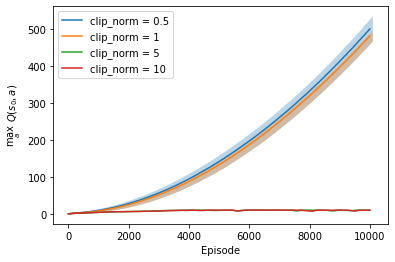

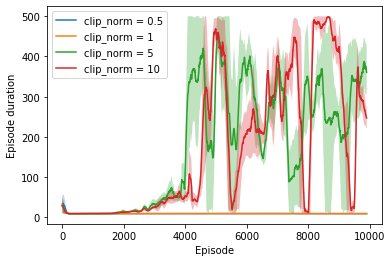

In [17]:
# Average over the cumulative results
for clip_norm in clip_norms:
    cum_state_values[clip_norm] = np.array(cum_state_values[clip_norm])
    cum_episode_durations[clip_norm]  = np.array(cum_episode_durations[clip_norm])

# Plot initial state value over time
for clip_norm in clip_norms:
    stds = np.std(cum_state_values[clip_norm], axis=0)
    mean_values = np.mean(cum_state_values[clip_norm], axis=0)
    plt.fill_between(np.linspace(1, (num_episodes//100)+1, num=(num_episodes//100)+1), mean_values-stds, mean_values+stds, alpha=0.3)
    plt.plot(mean_values)
plt.ylabel('$\max_a\ Q(s_0,a)$')
plt.xlabel('Episode')
plt.legend([f'clip_norm = {clip_norm}' for clip_norm in clip_norms], loc=2)
ticks = [0, 20, 40, 60, 80, 100]
plt.xticks(ticks, [t*100 for t in ticks])
plt.show()

# Plot episode duration over time
for clip_norm in clip_norms:
    smooth_stds = smooth(np.std(cum_episode_durations[clip_norm], axis=0), 100)
    smooth_mean_values = smooth(np.mean(cum_episode_durations[clip_norm], axis=0), 100)
    plt.fill_between(np.linspace(1, len(smooth_stds), num=len(smooth_stds)), smooth_mean_values-smooth_stds, smooth_mean_values+smooth_stds, alpha=0.3)
    plt.plot(smooth_mean_values)
plt.ylabel('Episode duration')
plt.xlabel('Episode')
plt.legend([f'clip_norm = {clip_norm}' for clip_norm in clip_norms], loc=2)
plt.show()